## 📚 Prerequisites

Before executing this notebook, make sure you have properly set up your Azure Services, created your Conda environment, and configured your environment variables as per the instructions provided in the [README.md](README.md) file.


## Understanding Quantitative Measures of Relevance

In order to evaluate the effectiveness of our search system, we use several metrics that measure the relevance of the results it returns. These metrics help us understand how well our system is performing and guide us in tuning it for better performance.

+ **NDCG@10**: Normalized Discounted Cumulative Gain at 10 (NDCG@10) is a metric that assesses the effectiveness of a retrieval system at finding and correctly ordering the top 10 documents. The score ranges from 0 to 100, with higher scores indicating that the system's ordered list of documents closely matches the ideal order. This metric is widely used because it balances the need for precision (returning relevant results) with the need for proper sequencing (ordering the results correctly).

- **NDCG@3**: NDCG@3 is similar to NDCG@10, but it focuses on the top 3 documents. This metric is particularly relevant in contexts where it's crucial to have the highest accuracy in the topmost results, such as in generative AI applications. NDCG@3 measures the system's ability to identify and correctly rank the three most relevant documents.

+ **Recall@50**: Recall@50 measures the proportion of high-quality documents identified within the top 50 results. It's calculated by counting the number of documents rated as high quality by a scoring prompt and dividing this by the total number of known good documents for a given query. This metric is useful for assessing the system's ability to retrieve a broad set of relevant documents from a large pool.

To automate the evaluation process, we use supervised tuning techniques. These techniques involve training a model on a labeled dataset, where the labels indicate the relevance of the documents to the queries. The model learns to predict the relevance of a document to a query, and we can then use these predictions to calculate the metrics above. This allows us to measure the relevance of our queries in an automated and scalable way.

## Dataset Creation

To assess the qualitative performance of our search store in alignment with the BEIR framework, we follow a three-step process to generate our evaluation dataset:

1. **Corpus Creation:**
   We begin by extracting document chunks from our Azure Search index. These chunks are consolidated into a corpus file (`corpus.jsonl`), ensuring that the foundational set of documents is standardized and comprehensive for subsequent evaluation.

2. **Query Generation:**
   Next, we utilize GPT-4o to generate a diverse set of queries based on five carefully selected diagnosis and medication scenarios from our medical index. This targeted approach ensures that the queries are medically relevant and reflective of real-world clinical information needs. The generated queries are stored in `queries.jsonl`.

3. **Relevance Judgments:**
   Finally, we employ an LLM-as-a-judge to evaluate the relevance of the documents with respect to each query. This evaluation produces relevance judgments that are saved in `qrel.jsonl`. These qrels form the basis for computing our performance metrics, including NDCG@10, NDCG@3, and Recall@50.

You can use the below cells to generate your own dataset, please uncomment the code and run it. The dataset will be saved in the `evals/benchmark/medindexer` directory, where our existing datasets have been curated.


In [2]:
from opentelemetry.propagate import extract

from src.pipeline.promptEngineering.prompt_manager import PromptManager
from src.aoai.aoai_helper import AzureOpenAIManager
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from dotenv import load_dotenv
import nest_asyncio
import asyncio
import json
import os
from tqdm import tqdm
import math
import json
import os
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import (
    VectorizableTextQuery,
    QueryType,
    QueryCaptionType,
    QueryAnswerType,
)
import json
from beir.retrieval.evaluation import EvaluateRetrieval
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

load_dotenv()

# Setup configuration variables for Azure and MedImageInsight
search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")
search_admin_key = os.getenv("AZURE_AI_SEARCH_ADMIN_KEY")
search_index_name = os.getenv("AZURE_IMAGES_SEARCH_INDEX_NAME", "ai-policies-index")
root = os.path.dirname(os.getcwd())
aoai_client = AzureOpenAIManager()
prompt_manager = PromptManager()

Templates found: ['evaluator_system_prompt.jinja', 'evaluator_user_prompt.jinja', 'formulator_system_prompt.jinja', 'formulator_user_prompt.jinja', 'ner_clinician_system.jinja', 'ner_clinician_user.jinja', 'ner_patient_system.jinja', 'ner_patient_user.jinja', 'ner_physician_system.jinja', 'ner_physician_user.jinja', 'ner_system_prompt.jinja', 'ner_user_prompt.jinja', 'prior_auth_o1_user_prompt.jinja', 'prior_auth_o1_user_prompt_b.jinja', 'prior_auth_system_prompt.jinja', 'prior_auth_user_prompt.jinja', 'query_classificator_system_prompt.jinja', 'query_classificator_user_prompt.jinja', 'query_expansion_system_prompt.jinja', 'query_expansion_user_prompt.jinja', 'query_generation_eval_system_prompt.jinja', 'query_generation_eval_user_prompt.jinja', 'query_relevance_eval_system_prompt.jinja', 'query_relevance_eval_user_prompt.jinja', 'summarize_policy_system.jinja', 'summarize_policy_user.jinja']


In [3]:
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_admin_key)
)

results = search_client.search("*", include_total_count=True)
dataset_dir = "evals/benchmark/medindexer"

# # Uncomment lines below to run the saving.
# with open(os.path.join(root, dataset_dir, "corpus.jsonl"), "w") as f:
#     for i, result in enumerate(results, start=1):
#         # Remove keys starting with "@search"
#         filtered_result = {k: v for k, v in result.items() if not k.startswith("@search")}
#         filtered_result["id"] = f"d{i}"
#         json_line = json.dumps(filtered_result, separators=(',', ':'), sort_keys=True)
#         f.write(json_line + "\n")
# 
# print("Corpus saved to corpus.jsonl")

queries.jsonl:

In [4]:
run_queries = False
use_cases = [
    {
        "diagnosis": "Inflammatory Bowel Disease (Crohn’s)",
        "medication": "Adalimumab",
        "title" : "001.pdf"
    },
    {
        "diagnosis": "Lennox-Gastaut Syndrome",
        "medication": "Epidiolex",
        "title" : "002.pdf"
    },
    {
        "diagnosis": "Lymphoblastic Leukemia (B-ALL), Philadelphia chromosome-negative",
        "medication": "Blinatumomab",
        "title" : "003.pdf"
    },
    {
        "diagnosis": "Severe Atopic Dermatitis",
        "medication": "Dupilumab",
        "title" : "004.pdf"
    },
    {
        "diagnosis": "High-grade Osteosarcoma",
        "medication": "Everolimus",
        "title" : "005.pdf"
    }
]

nest_asyncio.apply()

queries_flattened = []
if run_queries:
    for use_case in use_cases:
        diagnosis = use_case["diagnosis"]
        medication = use_case["medication"]
        title = use_case["title"]
        
        user_query_generation_prompt = prompt_manager.create_prompt_query_generation_eval_user(
            diagnosis=diagnosis,
            medication=medication
        )
        system_query_generation_prompt = prompt_manager.create_prompt_query_generation_eval_system()
        query_response = await aoai_client.generate_chat_response(
            query=user_query_generation_prompt,
            system_message_content=system_query_generation_prompt,
            image_paths=[],  # No images are needed for this prompt.
            stream=False,
            response_format="text",  # Requesting plain text (markdown formatted) output.
        )
        queries = json.loads(query_response['response'])['queries']
    
        # Merge the original use case fields with the generated query
        for query in queries:
            query_object = {
                "diagnosis": diagnosis,
                "medication": medication,
                "title" : title,
                "query": query
            }
            queries_flattened.append(query_object)

# # Save the queries to a minified JSONL file (one JSON object per line)
# with open(os.path.join(root, dataset_dir, "queries.jsonl"), "w") as f:
#     for i, query in enumerate(queries_flattened, start=1):
#         query["id"] = f"q{i}"
#         json_line = json.dumps(query, separators=(',', ':'))
#         f.write(json_line + "\n")
# 
# print("queries.jsonl file has been generated.")

In [5]:
with open(os.path.join(root, dataset_dir, "corpus.jsonl"), "r") as f:
    corpus_data = [
        {k: d[k] for k in ("chunk", "id", "title", "chunk_id") if k in d}
        for d in (json.loads(line) for line in f if line.strip())
    ]

with open(os.path.join(root, dataset_dir, "queries.jsonl"), "r") as f:
    queries_data = [json.loads(line) for line in f if line.strip()]

In [ ]:
block_size = 5
run_relevance = True
semaphore = asyncio.Semaphore(8)  # Increase based on your quota TPM/RPM

async def process_block(query_obj, corpus_block):
    async with semaphore:
        query_id = query_obj["id"]
        query_text = query_obj["query"]
        title = query_obj.get("title", "")
        corpus_str = json.dumps(corpus_block, indent=2)
        
        user_prompt = prompt_manager.create_prompt_query_relevance_eval_user(
            corpus=corpus_str,
            query_id=query_id,
            query=query_text,
            title=title,
        )
        system_prompt = prompt_manager.create_prompt_query_relevance_eval_system()
        
        response = await aoai_client.generate_chat_response(
            query=user_prompt,
            system_message_content=system_prompt,
            image_paths=[],  # No images are needed for this prompt.
            stream=False,
            response_format="text",  # Expecting plain text output that is valid JSON.
            max_tokens=2000,
        )
        
        parsed_response = json.loads(response["response"])
        return parsed_response

async def process_queries(queries_data, corpus_data):
    overall_progress = tqdm(total=len(queries_data), desc="Processing Queries")
    qrels_flattened = []
    
    # Process each query individually to allow a nested progress bar per query.
    for query_obj in queries_data:
        num_blocks = math.ceil(len(corpus_data) / block_size)
        block_progress = tqdm(total=num_blocks, desc=f"Query {query_obj['id']} Blocks", leave=False)
        query_qrels = []
        
        # Create tasks for each block for this query.
        tasks = [
            asyncio.create_task(process_block(query_obj, corpus_data[i:i + block_size]))
            for i in range(0, len(corpus_data), block_size)
        ]
        
        # Process the tasks as they complete.
        for future in asyncio.as_completed(tasks):
            parsed_response = await future
            query_qrels.extend(parsed_response)
            block_progress.update(1)
        block_progress.close()
        
        overall_progress.update(1)
        qrels_flattened.extend(query_qrels)
    overall_progress.close()
    
    return qrels_flattened

# Only execute the processing if run_relevance is True
if run_relevance:
    qrels_flattened = await process_queries(queries_data, corpus_data)
    
    # Write the combined results to the qrels.jsonl file.
    with open(os.path.join(root, dataset_dir, "qrels.jsonl"), "w") as f:
        for qrel in qrels_flattened:
            json_line = json.dumps(qrel, separators=(',', ':'), sort_keys=True)
            f.write(json_line + "\n")
    
    print("qrels.jsonl file has been generated.")

Query q3 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-01 14:46:53,988 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 14:46:53 (aoai_helper.py:generate_chat_response:383)
2025-04-01 14:46:53,988 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 14:46:53 (aoai_helper.py:generate_chat_response:440)


build rankings

In [9]:
with open(os.path.join(root, dataset_dir, "qrels.jsonl"), "r") as f:
    qrels_data = [json.loads(line) for line in f if line.strip()]

def extract_chunk_id(full_chunk_id):
    # Split on the FIRST underscore only
    parts = full_chunk_id.split("_", 1)
    return parts[1]

def get_doc_id(chunk_id, corpus_data):
    """
    Return a list of (id, chunk) tuples where 'query_text' is found in the chunk string.
    """
    results = []
    return [x['id'] for x in corpus_data if extract_chunk_id(x["chunk_id"]) == extract_chunk_id(chunk_id)][0]

def run_search(query_text, mode, top_n=50):
    """
    Run a search for the given query text and mode.

    Possible modes:
      - "hybrid_reranker"
      - "semantic_search"
      - "keyword_search"
      - "hybrid_semantic_reranker"

    Returns a dictionary mapping document IDs to the chosen score field.
    """
    vector_query = VectorizableTextQuery(
        text=query_text,
        fields="vector",
        k_nearest_neighbors=5,
        weight=0.5               
    )
    if mode == "keyword":
        # Basic keyword (lexical) search
        results = search_client.search(
            search_text=query_text,
            top=top_n,
            query_type=QueryType.FULL,
        )
        sort_field = "@search.score"
    elif mode == "hybrid-semantic":
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            query_type=QueryType.SEMANTIC,
            semantic_configuration_name="my-semantic-config",
            query_caption=QueryCaptionType.EXTRACTIVE,
            query_answer=QueryAnswerType.EXTRACTIVE,
            top=top_n,
        )
        sort_field = "@search.reranker_score"
    elif mode == "hybrid":
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            query_type=QueryType.FULL,
            top=top_n,
        )
        sort_field = "@search.score"
    elif mode == "vector":
        results = search_client.search(
            search_text=None,
            vector_queries=[vector_query],
            query_type=QueryType.FULL,
            top=top_n,
        )
        sort_field = "@search.score"
    else:
        raise ValueError("Invalid search mode provided.")

    # Convert results to a ranking dict: {document_id: sort_field_value}
    ranking = {}
    for result in results:
        doc_id = get_doc_id(result["chunk_id"], corpus_data)
        score_val = getattr(result, sort_field, None)
        if score_val is None:
            score_val = result[sort_field] if sort_field in result else None
        ranking[doc_id] = score_val

    return ranking

# Define output file paths.
output_keyword = os.path.join(root, dataset_dir, "rankings-keyword.jsonl")
output_vector = os.path.join(root, dataset_dir, "rankings-vector.jsonl")
output_hybrid = os.path.join(root, dataset_dir, "rankings-hybrid.jsonl")
output_hybrid_semantic = os.path.join(root, dataset_dir, "rankings-hybrid-semantic.jsonl")

# Open all three output files at once.
with open(output_hybrid, "w", encoding="utf-8") as fout_hybrid, \
     open(output_hybrid_semantic, "w", encoding="utf-8") as fout_hybrid_semantic, \
     open(output_keyword, "w", encoding="utf-8") as fout_keyword, \
     open(output_vector, "w", encoding="utf-8") as fout_vector:
    
    # Process each query once.
    for query in queries_data:
        query_id = query["id"]
        query_text = query["query"]

        # Run searches for each mode.
        ranking_hybrid = run_search(query_text, mode="hybrid")
        ranking_semantic = run_search(query_text, mode="hybrid-semantic")
        ranking_keyword = run_search(query_text, mode="keyword")
        ranking_vector = run_search(query_text, mode="vector")
        
        # Write the hybrid and semantic results as JSON lines.
        fout_hybrid.write(json.dumps({"query": query_id, "ranking": ranking_hybrid}) + "\n")
        fout_hybrid_semantic.write(json.dumps({"query": query_id, "ranking": ranking_semantic}) + "\n")
        fout_keyword.write(json.dumps({"query": query_id, "ranking": ranking_keyword}) + "\n")
        fout_vector.write(json.dumps({"query": query_id, "ranking": ranking_vector}) + "\n")
        
        print(f"Processed query {query_id}")

Processed query q3
Processed query q7


Evaluation Metrics:
           BEIR-Keyword  BEIR-Vector  BEIR-Hybrid (Keyword + Vector)  \
NDCG@3          0.35196      0.11732                         0.23464   
NDCG@10         0.22212      0.05502                         0.15340   
Recall@10       0.19286      0.05000                         0.12143   

           BEIR-Hybrid + Semantic  
NDCG@3                    0.11732  
NDCG@10                   0.10053  
Recall@10                 0.12143  


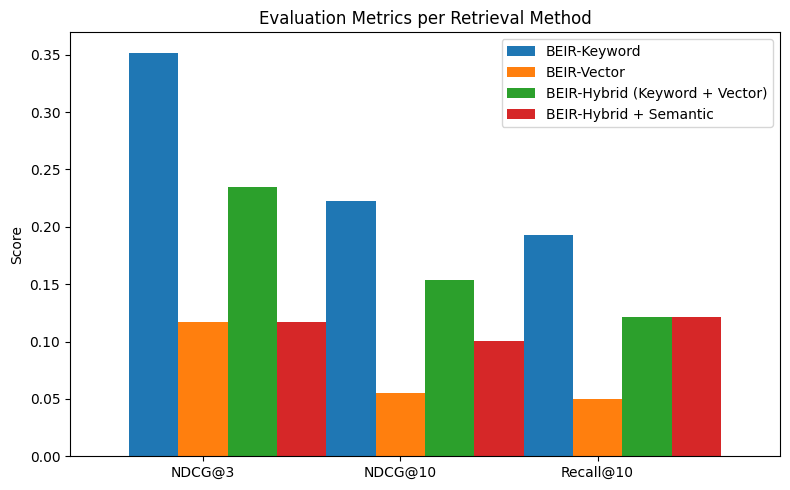

In [10]:
def load_run_dict(run_file):
    with open(os.path.join(root, dataset_dir, run_file), "r", encoding="utf-8") as f:
        run_data = [json.loads(line) for line in f if line.strip()]
    return {entry["query"]: entry["ranking"] for entry in run_data}

# Load qrels data (list of dictionaries) and convert to nested dict format.
qrels_dict = {q: {entry["document"]: int(entry["relevant"])
                  for entry in qrels_data if entry["query"] == q}
              for q in {entry["query"] for entry in qrels_data}}

# Define ranking files for the three retrieval methods.
ranking_files = {
    "BEIR-Keyword": "rankings-keyword.jsonl",
    "BEIR-Vector": "rankings-vector.jsonl",
    "BEIR-Hybrid (Keyword + Vector)": "rankings-hybrid.jsonl",
    "BEIR-Hybrid + Semantic": "rankings-hybrid-semantic.jsonl",
}

# Initialize a dictionary to store metrics for each retrieval method.
metrics_results = {}

# Create the BEIR evaluator.
evaluator = EvaluateRetrieval()

# For each ranking file, load the run, evaluate, and store the desired metrics.
for method_name, run_file in ranking_files.items():
    run_dict = load_run_dict(run_file)
    results = evaluator.evaluate(qrels_dict, run_dict, k_values=[3, 10])
    metrics_results[method_name] = {
        "NDCG@3": results[0]["NDCG@3"],
        "NDCG@10": results[0]["NDCG@10"],
        "Recall@10": results[2]["Recall@10"]
    }

# Create a DataFrame from the metrics results.
df = pd.DataFrame(metrics_results, index=["NDCG@3", "NDCG@10", "Recall@10"])
print("Evaluation Metrics:")
print(df)

# Plot the results as a grouped bar chart.
metrics = df.index.tolist()          # Metrics on x-axis.
methods = df.columns.tolist()        # Retrieval methods.
x = np.arange(len(metrics))          # Label positions.
width = 0.25                         # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
for idx, method in enumerate(methods):
    ax.bar(x + idx * width, df[method], width, label=method)

# Customize plot appearance.
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics per Retrieval Method')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.margins(x=0.1)  # Adjust the fraction as needed

plt.tight_layout()
plt.show()

In [34]:
results

({'NDCG@3': 0.5, 'NDCG@10': 0.38576},
 {'MAP@3': 0.15, 'MAP@10': 0.2248},
 {'Recall@3': 0.15, 'Recall@10': 0.39286},
 {'P@3': 0.5, 'P@10': 0.35})

In [ ]:
# import json
# 
# # Create corpus
# corpus = {
#     "doc1": {
#         "title": "Cigna Prior Authorization Policy",
#         "text": "Cigna requires prior authorization for certain procedures. This includes MRI scans, certain medications, and surgeries. The process typically takes 3-5 business days."
#     },
#     "doc2": {
#         "title": "UnitedHealthcare (UHC) Prior Authorization Policy",
#         "text": "UHC mandates prior authorization for select services. This includes advanced imaging, specific drugs, and inpatient admissions. Decisions are usually made within 7-10 days."
#     }
# }
# 
# # Write corpus to file
# with open('corpus.jsonl', 'w') as f:
#     for doc_id, content in corpus.items():
#         json.dump({"_id": doc_id, **content}, f)
#         f.write('\n')
# 
# # Create queries (focused on Cigna)
# queries = {
#     "q1": "What is Cigna's timeline for prior authorization?",
#     "q2": "Does Cigna require prior auth for MRI?",
#     "q3": "Cigna prior authorization process for medications"
# }
# 
# # Write queries to file
# with open('queries.jsonl', 'w') as f:
#     for query_id, query_text in queries.items():
#         json.dump({"_id": query_id, "text": query_text}, f)
#         f.write('\n')
# 
# # Create qrels (relevance judgments)
# # 1 indicates relevant, 0 indicates not relevant
# qrels = [
#     ("q1", "doc1", 1),  # Cigna query is relevant to Cigna doc
#     ("q1", "doc2", 0),  # Cigna query is not relevant to UHC doc
#     ("q2", "doc1", 1),
#     ("q2", "doc2", 0),
#     ("q3", "doc1", 1),
#     ("q3", "doc2", 0)
# ]
# 
# # Write qrels to file
# with open('qrels.tsv', 'w') as f:
#     f.write("query-id\tcorpus-id\tscore\n")
#     for query_id, doc_id, score in qrels:
#         f.write(f"{query_id}\t{doc_id}\t{score}\n")

In [ ]:
# from medindexer.datasets.data_loader import GenericDataLoader
# from medindexer.retrieval.evaluation import EvaluateRetrieval
# from medindexer.retrieval.search.lexical import BM25Search
# 
# # Load the dataset
# data_path = "path/to/your/dataset"
# corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
# 
# # Initialize BM25 retriever
# retriever = EvaluateRetrieval(BM25Search(corpus))
# 
# # Retrieve results
# results = retriever.retrieve(corpus, queries)
# 
# # Evaluate
# ndcg, _map, recall, precision = retriever.evaluate(qrels, results, retriever.k_values)

In [ ]:
import json
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.sparse import BM25Search

# 1. Load the dataset files
with open("corpus.json", "r") as f:
    corpus = json.load(f)
with open("queries.json", "r") as f:
    queries = json.load(f)
with open("qrels.json", "r") as f:
    qrels = json.load(f)

# 2. Initialize the BM25 retrieval model.
#    Depending on your BEIR version, BM25Search may accept the corpus directly.
bm25_model = BM25Search(corpus)

# 3. Set up the evaluation using the EvaluateRetrieval class.
#    We set top_k=50 since we want to compute Recall@50.
evaluator = EvaluateRetrieval(bm25_model)
results = evaluator.evaluate(queries, corpus, qrels, top_k=50)

# 4. Extract and print the desired metrics.
print("Evaluation Metrics:")
print("NDCG@10:", results.get("NDCG@10"))
print("NDCG@3:", results.get("NDCG@3"))
print("Recall@50:", results.get("Recall@50"))